In [160]:
from tenpy.networks.site import SpinSite
from tenpy.networks.mps import TransferMatrix
from tenpy.linalg import np_conserved as npc
import numpy as np
from tenpy.networks.mps import MPS

In [161]:
import h5py
from tenpy.tools import hdf5_io

## Import previous results

In [162]:
with h5py.File('./results/dmrg_AnisotropicSpin1Chain_CouplingModel_chi_0100_B_0.000_D_0.000.h5') as f:
    coupling_data = hdf5_io.load_from_hdf5(f)

In [163]:
with h5py.File('./results/dmrg_AnisotropicSpin1Chain_Pollmann_chi_0100_B_0.000_D_0.000.h5') as f:
    pollman_data = hdf5_io.load_from_hdf5(f)

In [164]:
def MPS_drop_charge(psi, charge=None, chinfo=None, permute_p_leg=True):
    import copy, tenpy
    psi_c = psi.copy()
    psi_c.chinfo = chinfo = npc.ChargeInfo.drop(chinfo, charge=charge)
    if permute_p_leg is None and chinfo.qnumber == 0:
        permute_p_leg = True
    for i, B in enumerate(psi_c._B):
        psi_c._B[i] = B = B.drop_charge(charge=charge, chinfo=chinfo)
        psi_c.sites[i] = site = copy.copy(psi.sites[i])
        if permute_p_leg:
            if permute_p_leg is True:
                perm = tenpy.tools.misc.inverse_permutation(site.perm)
            else:
                perm = permute_p_leg
            psi_c._B[i] = B = B.permute(perm, 'p')
        else:
            perm = None
        site.change_charge(B.get_leg('p'), perm) # in place
    print(psi_c.chinfo)
    psi_c.test_sanity()
    return psi_c

In [165]:
MPS_drop_charge(coupling_data['psi']).overlap(MPS_drop_charge(pollman_data['psi']))

ChargeInfo([], [])
ChargeInfo([], [])


/home/ymchan/miniconda3/envs/qinfo/lib/python3.8/site-packages/tenpy/networks/mps.py:3588: UserWarning: The returned overlap between two iMPS is **not** just <phi|psi>, as you might assume naively, but here defined to return the dominant eigenvalue eta of the (mixed) TransferMatrix. The former is lim_{N -> infty} eta^N and vanishes in the thermodynamic limit! See the warning in the docs of tenpy.networks.mps.
  warnings.warn("The returned overlap between two iMPS is **not** just <phi|psi>, "


(0.9999999999999979+0j)

In [166]:
coupling_data['psi'].get_B(0)

<npc.Array shape=(100, 3, 100) labels=['vL', 'p', 'vR']>

In [167]:
pollman_data['psi'].get_B(0)

<npc.Array shape=(100, 3, 100) labels=['vL', 'p', 'vR']>

In [168]:
# Check canonical form
B_coupling = coupling_data['psi'].get_B(0)
B_pollman  = pollman_data['psi'].get_B(0)

## Check overlap of the two methods of simulating the states 

In [169]:
# Check overlap 
coupling_data['psi'].overlap(pollman_data['psi'])

(0.9999999999999972+0j)

## Check symmetry of the simulated state 

### Translational symmetry

**Method:** 
1. Translate the sites periodically by $k$ site, and then compute overlap

In [170]:
for i in range(10):
    TM = TransferMatrix(bra=pollman_data['psi'], ket=pollman_data['psi'],shift_bra=2)
    eigval, eigvec = TM.eigenvectors(which='LM', num_ev=3)
    print(eigval)
    #print(TM.to_matrix())

[1.      +0.00000000e+00j 0.165507+3.06986277e-13j
 0.165507-3.06986277e-13j]
[1.      +0.00000000e+00j 0.165507+3.07465739e-13j
 0.165507-3.07465739e-13j]
[1.      +0.00000000e+00j 0.165507+3.07195534e-13j
 0.165507-3.07195534e-13j]
[1.      +0.00000000e+00j 0.165507+3.07487619e-13j
 0.165507-3.07487619e-13j]
[1.      +0.00000000e+00j 0.165507+3.07077359e-13j
 0.165507-3.07077359e-13j]
[1.      +0.00000000e+00j 0.165507+3.07348583e-13j
 0.165507-3.07348583e-13j]
[1.      +0.00000000e+00j 0.165507+3.07339738e-13j
 0.165507-3.07339738e-13j]
[1.      +0.00000000e+00j 0.165507+3.07244005e-13j
 0.165507-3.07244005e-13j]
[1.      +0.00000000e+00j 0.165507+3.07201752e-13j
 0.165507-3.07201752e-13j]
[1.      +0.0000000e+00j 0.165507+3.0746662e-13j 0.165507-3.0746662e-13j]


The result is confusing, I will try to implement it directly by shifting the B matrices

In [171]:
L = 10
shift_param = 3
Sites = [SpinSite(S=1,conserve='None')]*L
Bs = [pollman_data['psi'].get_B(i) for i in range(L)]
SLs = [pollman_data['psi'].get_SL(i) for i in range(L+1)]
shift_list = lambda x,k: [x[(i+k) %len(x)] for i in range(len(x))]

not_translated = MPS(Sites,Bs,SLs,bc='infinite')
do_translated = MPS(Sites,shift_list(Bs,shift_param),shift_list(SLs,shift_param),bc='infinite')

In [172]:
TM = TransferMatrix(bra=not_translated, ket=do_translated)
eigval, eigvec = TM.eigenvectors(which='LM', num_ev=3)
print(eigval)

[1.      +0.00000000e+00j 0.165507+3.07246244e-13j
 0.165507-3.07246244e-13j]


## Doing detection of SPT phase again

In [173]:
# Direct application on each B matrix 
Sz, Sx = SpinSite(S=1,conserve='None').Sz, SpinSite(S=1,conserve='None').Sx
Uz = npc.expm(1.j*np.pi*Sz)
Ux = npc.expm(1.j*np.pi*Sx)

In [174]:
L = 10
Bs = [pollman_data['psi'].get_B(i) for i in range(L)]
Bs_Uz = [npc.tensordot(Bs[i],Uz,('p','p*')) for i in range(L)]
Bs_Ux = [npc.tensordot(Bs[i],Ux,('p','p*')) for i in range(L)]
SLs = [pollman_data['psi'].get_SL(i) for i in range(L+1)]

In [175]:
site = SpinSite(S=1,conserve='None')

In [176]:
psi_Uz = MPS([site]*L, Bs_Uz, SLs, bc='infinite')
psi_Ux = MPS([site]*L, Bs_Ux, SLs, bc='infinite')

In [177]:
TM_Uz = TransferMatrix(bra=pollman_data['psi'], ket=psi_Uz)
TM_Ux = TransferMatrix(bra=pollman_data['psi'], ket=psi_Ux)

In [178]:
eigval, eigvec = TM_Uz.eigenvectors(which='LM', num_ev=3)
eigval, eigvec

(array([1.      +9.57476391e-18j, 0.165507-6.33174069e-17j,
        0.165507+1.35502491e-13j]),
 [<npc.Array shape=(10000,) labels=['(vL.vL*)']>,
  <npc.Array shape=(10000,) labels=['(vL.vL*)']>,
  <npc.Array shape=(10000,) labels=['(vL.vL*)']>])

In [179]:
eigval, eigvec = TM_Ux.eigenvectors(which='LM', num_ev=3)
eigval, eigvec

(array([1.      +2.15691893e-16j, 0.165507-6.07803738e-16j,
        0.165507+3.63270750e-13j]),
 [<npc.Array shape=(10000,) labels=['(vL.vL*)']>,
  <npc.Array shape=(10000,) labels=['(vL.vL*)']>,
  <npc.Array shape=(10000,) labels=['(vL.vL*)']>])

In [180]:
# Compute the projective representation
_, Vx = TM_Ux.eigenvectors(which='LM', num_ev=1)
_, Vz = TM_Uz.eigenvectors(which='LM', num_ev=1)

In [181]:
Vx = Vx[0].split_legs().transpose().conj()
Vz = Vz[0].split_legs().transpose().conj()

In [182]:
VxVz = npc.tensordot(Vx,Vz,('vL*','vL'))
VzVx = npc.tensordot(Vz,Vx,('vL*','vL'))
VxdVzd = VzVx.conj().transpose()
VxVzVxdVzd = npc.tensordot(VxVz,VxdVzd,('vL*','vL'))

In [183]:
npc.trace(VxVzVxdVzd)*VxVz.shape[0] # It seems to be working, let's try to do it in mass

(-1.0000000000000009-6.0986372202309624e-18j)

In [186]:
def detect_Z2xZ2(psi,L,tor=1e-3,verbose=False):
    # Direct application on each B matrix 
    Sz, Sx = SpinSite(S=1,conserve='None').Sz, SpinSite(S=1,conserve='None').Sx
    Uz = npc.expm(1.j*np.pi*Sz)
    Ux = npc.expm(1.j*np.pi*Sx)

    # Direct application of B matrices
    Bs = [psi.get_B(i) for i in range(L)]
    Bs_Uz = [npc.tensordot(Bs[i],Uz,('p','p*')) for i in range(L)]
    Bs_Ux = [npc.tensordot(Bs[i],Ux,('p','p*')) for i in range(L)]
    SLs = [psi.get_SL(i) for i in range(L+1)]
    psi_Uz = MPS([site]*L, Bs_Uz, SLs, bc='infinite')
    psi_Ux = MPS([site]*L, Bs_Ux, SLs, bc='infinite')

    # Computing transfer matrix
    TM_Uz = TransferMatrix(bra=psi, ket=psi_Uz)
    TM_Ux = TransferMatrix(bra=psi, ket=psi_Ux)

    # Compute the projective representation
    evx, Vx = TM_Ux.eigenvectors(which='LM', num_ev=1)
    evz, Vz = TM_Uz.eigenvectors(which='LM', num_ev=1)
    Vx = Vx[0].split_legs().transpose().conj()
    Vz = Vz[0].split_legs().transpose().conj()

    if verbose:
        print('Eigenvalues Ux:',evx)
        print('Eigenvalues Uz:',evz)

    if np.abs(evx-1) > tor or np.abs(evz-1) > tor:
        if verbose:
            print('Symmetry breaking')
        return 0 # In this case this is symmetry breaking 

    # Compute the required trace
    VxVz = npc.tensordot(Vx,Vz,('vL*','vL'))
    VzVx = npc.tensordot(Vz,Vx,('vL*','vL'))
    VxdVzd = VzVx.conj().transpose()
    VxVzVxdVzd = npc.tensordot(VxVz,VxdVzd,('vL*','vL'))

    return npc.trace(VxVzVxdVzd)*VxVz.shape[0] # Multiply by the shape to get the normalization right

In [187]:
detect_Z2xZ2(pollman_data['psi'],10)

(-1.0000000000000002+4.743384504624082e-18j)

## SPT in action - computing this parameter for the parameter range simulated

In [188]:
import glob as glob

In [189]:
Ds = []
Traces = []
for i,fname in enumerate(list(glob.glob('./results/dmrg_AnisotropicSpin1Chain_Pollmann_chi_0100_B_0.000_D_*.h5'))): # Get all the positive Ds
    with h5py.File(fname) as f:
        pollman_data = hdf5_io.load_from_hdf5(f)
        D = pollman_data['simulation_parameters']['model_params']['D']
        L = pollman_data['simulation_parameters']['model_params']['L']
        psi = MPS_drop_charge(pollman_data['psi'])
        Trace = detect_Z2xZ2(psi,L,verbose=(i%3 == 0))
        Ds.append(D)
        Traces.append(Trace)
    if i % 3 == 0:
        print('Finished processing ',fname)

ChargeInfo([], [])
Eigenvalues Ux: [1.+3.3940949e-16j]
Eigenvalues Uz: [1.+2.22884883e-16j]
Finished processing  ./results/dmrg_AnisotropicSpin1Chain_Pollmann_chi_0100_B_0.000_D_-0.041.h5
ChargeInfo([], [])
ChargeInfo([], [])
ChargeInfo([], [])
Eigenvalues Ux: [0.99999999+2.08996289e-16j]
Eigenvalues Uz: [1.+9.34013503e-17j]
Finished processing  ./results/dmrg_AnisotropicSpin1Chain_Pollmann_chi_0100_B_0.000_D_-0.286.h5
ChargeInfo([], [])
ChargeInfo([], [])
ChargeInfo([], [])
Eigenvalues Ux: [0.34126769-2.94017759e-16j]
Eigenvalues Uz: [1.-1.12666658e-16j]
Symmetry breaking
Finished processing  ./results/dmrg_AnisotropicSpin1Chain_Pollmann_chi_0100_B_0.000_D_-0.531.h5
ChargeInfo([], [])
ChargeInfo([], [])
ChargeInfo([], [])
Eigenvalues Ux: [0.11763164-2.13353806e-18j]
Eigenvalues Uz: [1.+1.60733018e-16j]
Symmetry breaking
Finished processing  ./results/dmrg_AnisotropicSpin1Chain_Pollmann_chi_0100_B_0.000_D_-0.776.h5
ChargeInfo([], [])
ChargeInfo([], [])
ChargeInfo([], [])
Eigenvalues Ux

In [190]:
import matplotlib.pyplot as plt

Text(0, 0.5, '$Tr(UxUzUx^\\dagger Uz^\\dagger)/\\chi$')

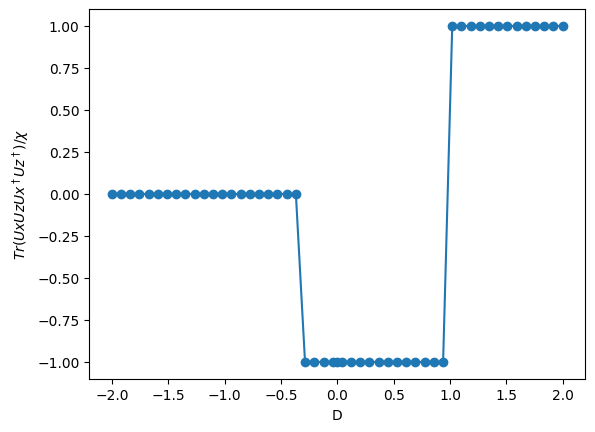

In [193]:
sorted_D = np.sort(Ds)
argsort_D = np.argsort(Ds)
sorted_Ts = np.array([t.real for t in Traces])[argsort_D]
plt.plot(sorted_D ,sorted_Ts,marker='o')
plt.xlabel('D')
plt.ylabel(r'$Tr(UxUzUx^\dagger Uz^\dagger)/\chi$')

### Remark: 
I think the proper way to compute overlap in infinite MPS is to compute the maximum eigenvector transfer matrix that is glued together, directly computing overlap might cause problems because of gauge freedom (I think)

### The stuff below are probably useless, they are some random experiment when I tried to play around with the code

In [10]:
# The matrix are in canonical form, as expected
npc.tensordot(B_coupling,B_coupling.conj(),(('vR','p'),('vR*','p*'))).to_ndarray()[:5,:5]

array([[ 1.00000000e+00,  2.66920101e-17, -1.88160040e-16,
         5.76398942e-17,  1.07147727e-16],
       [ 2.66920101e-17,  1.00000000e+00, -1.33452878e-16,
         7.13168546e-17,  2.73566039e-17],
       [-1.88160040e-16, -1.33452878e-16,  1.00000000e+00,
         8.26999325e-17, -3.36847266e-16],
       [ 5.76398942e-17,  7.13168546e-17,  8.26999325e-17,
         1.00000000e+00,  2.05069976e-16],
       [ 1.07147727e-16,  2.73566039e-17, -3.36847266e-16,
         2.05069976e-16,  1.00000000e+00]])

In [130]:
# Now look at the transfer matrix of the B matrix
T_pollman = npc.tensordot(B_coupling,B_coupling.conj(), ('p','p*'))
T_pollman.combine_legs((('vL','vL*'),('vR','vR*')))

<npc.Array shape=(10000, 10000) labels=['(vL.vL*)', '(vR.vR*)']>

In [129]:
T_pollman.transpos

<npc.Array shape=(100, 100, 100, 100) labels=['vL', 'vR', 'vL*', 'vR*']>

In [119]:
coupling_data['psi'].expectation_value('Sz'),pollman_data['psi'].expectation_value('Sz')

(array([-1.40773905e-11,  1.43415705e-11, -1.46895690e-11,  1.46186742e-11,
        -1.47167183e-11,  1.47350178e-11, -1.47005470e-11,  1.44406632e-11,
        -1.40826935e-11,  1.41229020e-11]),
 array([-1.40773905e-11,  1.43415705e-11, -1.46895690e-11,  1.46186742e-11,
        -1.47167183e-11,  1.47350178e-11, -1.47005470e-11,  1.44406632e-11,
        -1.40826935e-11,  1.41229020e-11]))

In [120]:
coupling_data['psi'].correlation_length(),pollman_data['psi'].correlation_length()

(5.559441675190947, 5.559441675190944)

In [121]:
coupling_data['psi'].correlation_function('Sp','Sm'),pollman_data['psi'].correlation_function('Sp','Sm')

(array([[ 1.33333333, -0.93432269,  0.50054388, -0.38404336,  0.27734979,
         -0.21861123,  0.16855915, -0.13485226,  0.10690552, -0.08637118],
        [-0.93432269,  1.33333333, -0.93432269,  0.50054388, -0.38404336,
          0.27734979, -0.21861123,  0.16855915, -0.13485225,  0.10690552],
        [ 0.50054388, -0.93432269,  1.33333333, -0.93432269,  0.50054388,
         -0.38404336,  0.27734979, -0.21861123,  0.16855915, -0.13485226],
        [-0.38404336,  0.50054388, -0.93432269,  1.33333333, -0.93432269,
          0.50054388, -0.38404335,  0.27734979, -0.21861123,  0.16855915],
        [ 0.27734979, -0.38404336,  0.50054388, -0.93432269,  1.33333333,
         -0.93432269,  0.50054388, -0.38404336,  0.27734979, -0.21861123],
        [-0.21861123,  0.27734979, -0.38404336,  0.50054388, -0.93432269,
          1.33333333, -0.93432269,  0.50054388, -0.38404336,  0.27734979],
        [ 0.16855915, -0.21861123,  0.27734979, -0.38404335,  0.50054388,
         -0.93432269,  1.3333333

In [122]:
result = {}
m_pollmann_turner_inversion(result, coupling_data['psi'],None,None)

In [123]:
result

{'pollmann_turner_inversion_eta': (0.9999999999974505+0j),
 'pollmann_turner_inversion_U_I': <npc.Array shape=(100, 100) labels=['vL', 'vL*']>,
 'pollmann_turner_inversion': -0.999999480347297}

In [124]:
m_pollmann_turner_inversion(result, pollman_data['psi'], None, None)

In [125]:
result

{'pollmann_turner_inversion_eta': (0.9999999999974519+0j),
 'pollmann_turner_inversion_U_I': <npc.Array shape=(100, 100) labels=['vL', 'vL*']>,
 'pollmann_turner_inversion': -0.999999480347297}

In [126]:
#pollman_data

In [127]:
site = SpinSite(S=1,conserve=None, sort_charge=True)
Uz = npc.expm(1.j*np.pi*site.Sz)
Ux = npc.expm(1.j*np.pi*site.Sx)

In [21]:
psi = pollman_data['psi'].copy()
psi_flipZ = psi.copy()
psi_flipZ.apply_product_op([Uz]*10)
psi_flipX = psi.copy()
psi_flipX.apply_product_op([Ux]*10)
psi.overlap(psi_flipZ), psi.overlap(psi_flipX)

((0.9999999999999978+2.475402949089327e-16j),
 (0.9999999999999906-8.028347413657612e-16j))

In [22]:
psi = coupling_data['psi'].copy()
psi_flipZ = psi.copy()
psi_flipZ.apply_product_op([Uz]*10)
psi_flipX = psi.copy()
psi_flipX.apply_product_op([Ux]*10)
psi.overlap(psi_flipZ), psi.overlap(psi_flipX)

((0.9999999999999967-8.239936555609271e-16j),
 (0.9999999999999901-2.0999299384973829e-16j))

In [23]:
# Actually I am not sure if this overlap make senese given it is an iMPS

In [24]:
mixed_TM = TransferMatrix(psi_flipZ,psi,transpose=False)
evals, evecs = mixed_TM.eigenvectors(which='LM', num_ev=1)
Vz = evecs[0].split_legs().transpose().conj()
evals

array([1.+6.73289662e-17j])

In [25]:
mixed_TM = TransferMatrix(psi_flipX,psi,transpose=False)
evals, evecs = mixed_TM.eigenvectors(which='LM', num_ev=1)
Vx = evecs[0].split_legs().transpose().conj()
evals

array([1.-2.67093205e-16j])

In [26]:
npc.norm(npc.tensordot(Vz,Vx,('vL*','vL'))-npc.tensordot(Vx,Vz,('vL*','vL'))),npc.norm(npc.tensordot(Vz,Vx,('vL*','vL'))+npc.tensordot(Vx,Vz,('vL*','vL')))

(0.1303623419680142, 0.1516761675300851)

In [27]:
# Neither one is giving something that make sense, so let's pick one of the B matrix, construct a MPS, and then try act the symmetry on it

In [87]:
psi_full_compress = psi.copy()
psi_full_compress.compress_svd(dict(svd_min=1e-3))

TruncationError(eps=7.2067e-06, ov=0.9999855866)

In [90]:
section = 1
psi_onesite = MPS(
    [SpinSite(S=1,conserve=None,sort_charge=True)]*section,
    [psi_full_compress.get_B(i) for i in range(section)],
    [psi_full_compress.get_SL(i) for i in range(section+1)],bc='infinite'
)
#psi_onesite.compress_svd(dict(svd_min=1e-3))

In [91]:
psi_onesite_flipZ = psi_onesite.copy()
psi_onesite_flipZ.apply_product_op([Uz]*section)
psi_onesite_flipX = psi_onesite.copy()
psi_onesite_flipX.apply_product_op([Ux]*section)
psi_onesite.overlap(psi_onesite_flipZ), psi.overlap(psi_onesite_flipX)

((-0.9877849731959055+1.0484623997716978e-16j),
 (-0.005479201340835328+7.015005340140344e-21j))

In [92]:
mixed_TM = TransferMatrix(psi_onesite_flipZ,psi_onesite,transpose=False)
evals, evecs = mixed_TM.eigenvectors(which='LM', num_ev=1)
Vz = evecs[0].split_legs().transpose().conj()
evals

array([-0.98778496-2.63677968e-16j])

In [93]:
mixed_TM = TransferMatrix(psi_onesite_flipX,psi_onesite,transpose=False)
evals, evecs = mixed_TM.eigenvectors(which='LM', num_ev=1)
Vx = evecs[0].split_legs().transpose().conj()
evals

array([-0.98711164+1.66533454e-16j])

In [94]:
npc.norm(npc.tensordot(Vz,Vx,('vL*','vL'))-npc.tensordot(Vx,Vz,('vL*','vL'))),npc.norm(npc.tensordot(Vz,Vx,('vL*','vL'))+npc.tensordot(Vx,Vz,('vL*','vL')))

(0.33513095620880745, 0.26066612902897557)

In [103]:
_VxVzVxdVzd = npc.tensordot(npc.tensordot(npc.tensordot(Vx,Vz,('vL*','vL')),Vx.conj(),('vL*','vL')),Vz.conj(),('vL*','vL'))
npc.trace(_VxVzVxdVzd)*Vx.shape[0] # Which look looks nothing like the Z2xZ2 detection I had below

(-0.2661955619188745-7.776724078275478e-12j)

In [95]:
# My code is bad, so I should try to reduce the bond dimension before proceeding

In [98]:
psi_onesite.get_B(0)

<npc.Array shape=(24, 3, 24) labels=['vL', 'p', 'vR']>

In [99]:
detect_Z2xZ2_old(psi_onesite.get_B(0))

Vx eigenvalue:  (-0.9871116535903177-3.469446951953614e-18j)
Vz eigenvalue:  (-0.9877849731959041-1.7347234759771645e-18j)
VxVz-VzVx:  0.4351064376405792
VxVz+VzVx:  0.061755817175216256


(-1.1130229867277794-4.945788097186422e-31j)

In [101]:
# The transfer matrix thing he did is different from what I am doing, eventhough the eigenvectors looks the same

In [37]:
def m_pollmann_turner_inversion(results, psi, model, simulation, tol=0.01):
    """Measurement function for equation 15 of :arxiv:`1204.0704`.

    See :func:`~tenpy.simulations.measurement.measurement_index` for the call structure.
    """
    psi2 = psi.copy()
    psi2.spatial_inversion()
    mixed_TM = TransferMatrix(psi, psi2, transpose=False, charge_sector=0, form='B')
    evals, evecs = mixed_TM.eigenvectors(which='LM', num_ev=1)
    results['pollmann_turner_inversion_eta'] = eta = evals[0]
    U_I = evecs[0].split_legs().transpose().conj()
    U_I *= np.sqrt(U_I.shape[0])  # previously normalized to npc.norm(U_I) = 1, need unitary
    results['pollmann_turner_inversion_U_I'] = U_I
    if abs(eta) < 1. - tol:
        O_I = 0.
    else:
        O_I = npc.inner(U_I, U_I.conj(), axes=[[0, 1], [1, 0]]) / U_I.shape[0]
    results['pollmann_turner_inversion'] = O_I